# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- l-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 25 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Salma"
ln1 = "EL BEZ"
fn2 = "Mohamed Rostom"
ln2 = "GHARBI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_el bez_salma_and_gharbi_mohamed rostom.ipynb


------------------------------------------------------------------------------------------------------------------

# Table of content :

[Part 0: Demo using Gradient descent](#0) <br>
[Part 1: Implement Newton method](#1) <br>
[Part 2: Implement DFP algorithm](#2) <br>
[Part 3: Implement BFGS algorithm](#3) <br>
[Part 4: Implement l-BFGS algorithm](#4) <br>


------------------------------------------------------------------------------------------------------------------

<a id='0'></a>
# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import time
%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


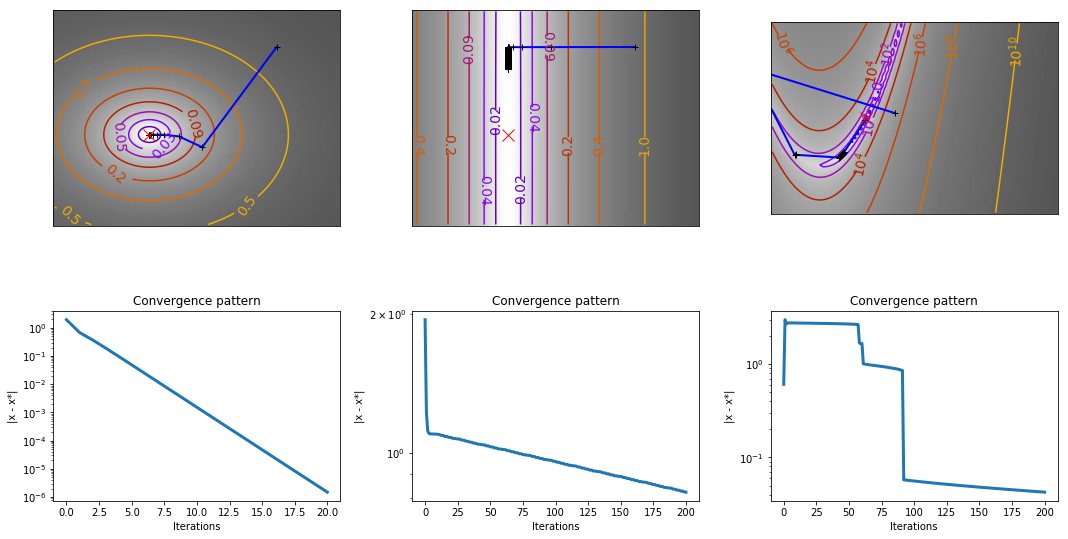

Running time :  3.3934571743011475  seconds.


In [5]:
start = time.time()
test_solver(gradient_descent)
print('Running time : ', time.time() - start,' seconds.')

It runs the algorithm on three functions:
- A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function

------------------------------------------------------------------------------------------------------------------

<a id='1'></a>
# Part 1: Implement Newton method

Implement Newton's method. Beware that the Hessian SHOULD be regularized !

**You are expected to comment** what you see. Play with the parameters. Do not describe the curves, ratherm

In [6]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))
    
    n=f_hessian(x0).shape[0]
    
    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO H = ..
        H=f_hessian(x)
        
        v,w = np.linalg.eig(f_hessian(x))
        
        if(np.min(v) <= lambda_threshold):
            H = f_hessian(x) + (lambda_threshold - np.min(v))*np.eye(n)
        
        
        d,_= cg(H,grad_x)
        d = -d
        
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


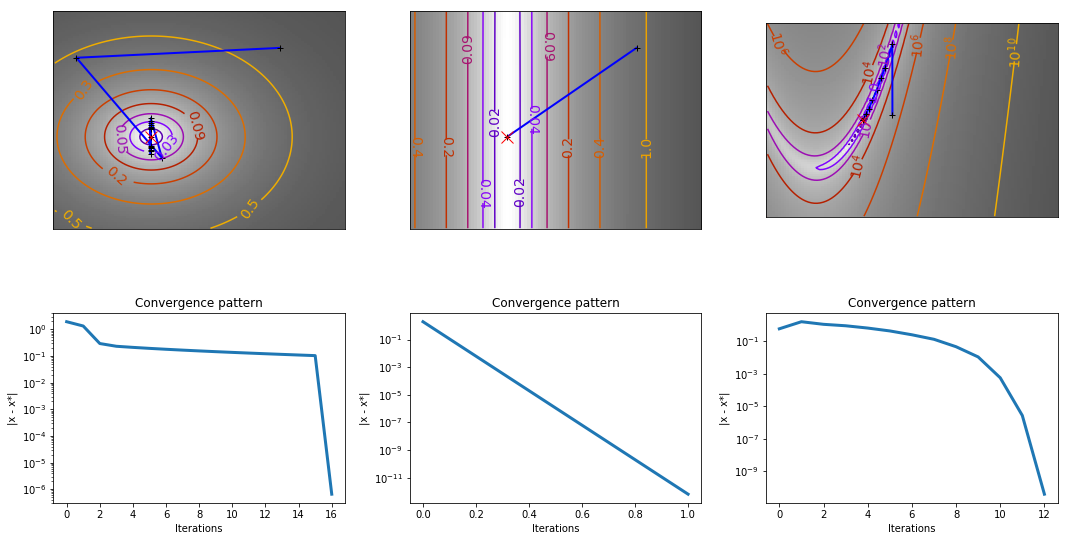

Running time :  3.0286829471588135  seconds.


In [7]:
start = time.time()
test_solver(newton)
print('Running time : ', time.time() - start,' seconds.')

#### Comments about Newton's algorithm :
Newton method is perfect for quadratic functions since it needs only one step to reach the minimum as the second order taylor expansion is exact in this kind of functions,  This is the consequence of slide 8 in the slides lecture. Unlike gradient descent, the newton method is independant from the conditioning, and converges therefore  faster than gradient descent.

From the first set of plots (Part 0), it is obvious that gradient descent depends heavily on the conditioning of the quadratic function as the second function didn't reach the minimum even after 200 iterations. Newton method needs only one iteration for that!

For the last function,  the Rosenbrock function that is difficult to optimize (not quadratic and ill-conditioned),  the Newton algorithm converges slower, exactly in 12 iterations. The number of iterations is not 1 because the function is not quadratic. On the other hand, the number of iterations is still  small, thanks to the line search we did.


------------------------------------------------------------------------------------------------------------------

<a id='2'></a>
# Part 2: Implement DFP algorithm

Now, implement the DFP algorithm using the formula for $B$ in the slides.

**Comment on what you observe**. Focus on the explanation, not on describing the curves! 

Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id

    
    for k in range(1, max_iter + 1):   
        
        grad_x = f_grad(x)
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        B += np.outer(s,s) / np.dot(s,y) - np.dot(B, np.dot(np.outer(y,y), B)) / np.dot(y, np.dot(B, y)) 

        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


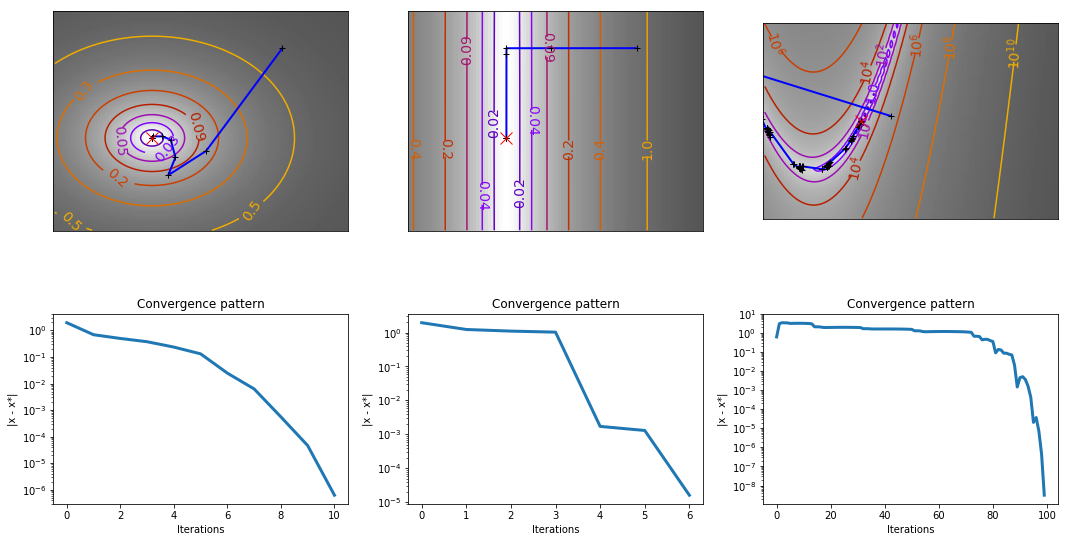

Running time :  3.7317116260528564  seconds.


In [9]:
start = time.time()
test_solver(dfp)
print('Running time : ', time.time() - start,' seconds.')

#### Comments about DFP algorithm :

We clearly see that the DFP method convergs for the three cases we have. 

From what we have seen in the course, Theoretically, DFP is supposed to converge in p+1 iterations for quadratic functions since it perfectly matches the hessian at iteration p (in our case functions 1 and 2). In our case, p=2, so we expect the algorithm to reach the  the minimum after 3 iterations which is not the case here ( cuve 1 and 2). This can be explained by an imperfect line search. This shows that DFP is quite sensitive to errors in line search. 

For the Rosenbrock function, which is not quadratic and is very ill-conditioned. We clearly see that it takes much more iterations to get to the minimum, this is explained by the fact that the process needs to be restarted at every n iterations to achieve the minimum.

------------------------------------------------------------------------------------------------------------------

<a id='3'></a>
# Part 3: Implement BFGS algorithm

You should now implement BFGS, using the formula for $B_t$ seen in the slides.

**Comment** on what you see.

In [10]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    for k in range(1, max_iter + 1):  
        
        grad_x = f_grad(x)
        
        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        r= 1./np.dot(s,y)
        B = np.dot( np.eye(len(x))-np.outer(s,y)*r, np.dot(B , np.eye(len(x)) - np.outer(y,s)*r)) + r * np.outer(s,s) 
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


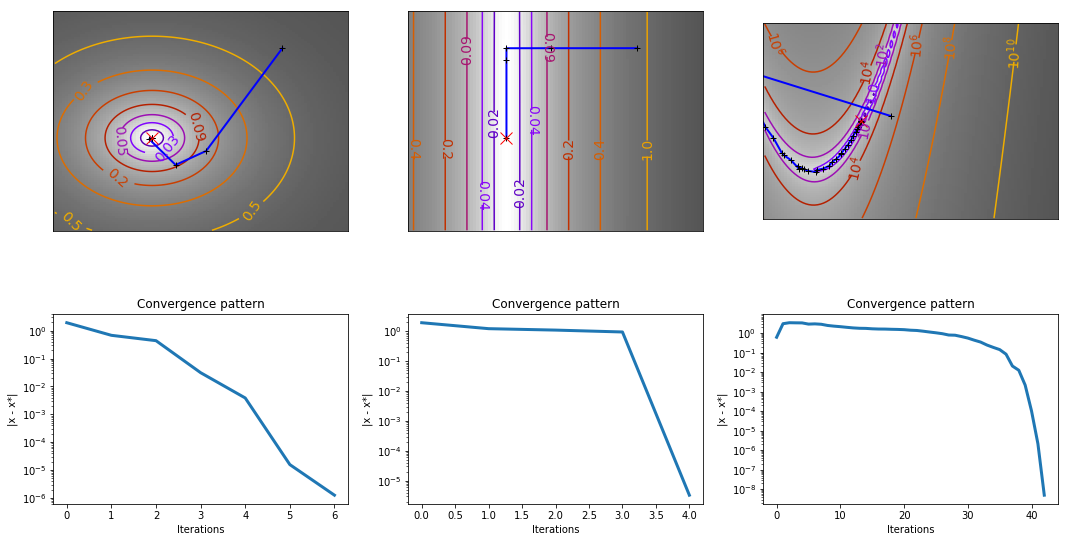

Running time :  3.6052651405334473  seconds.


In [11]:
start = time.time()
test_solver(bfgs)
print('Running time : ', time.time() - start,' seconds.')

#### Comments about BFGS algorithm :

Here also, we expect the BFGS algorithm to perfectly match the hessian at the second iteration (p=2) for the two first cases since they are quadratic problems, again errors within the line search prevent the algorithm from being this precise. However, we notice that BFGS is less sensitive to line serach errors than DBF. BFGS is therefoe moe efficient. For example in the first curve, the minimum is reached within 6 iterations while DBF needs 10 iterations to reach the same pecision. 
 
We need to mention that both DFP and BFGS formulas are dual for each other, actually, the BFGS formula is derived from the DFP formula by just swapping the roles of $s_k$ and $y_k$, and thus, the BFGS algorithm has the same property as the DFP method. On the other hand, solving the BFGS problem  was easier and took less time than the DFP problem ( Like for example, for the 3rd case, with BFGS we converged after ~ 40 iterations, while it took DFP 100 iterations to converge ).
 
We also notice, that the BFGS algorithm is faster than the DFP algorithm for both quadratic functions.

|      | Function 1    | Function 2   |
|------|---------------|--------------|
| DFP  | 10 iterations | 6 iterations |
| BFGS | 6 iterations  | 4 iterations |


We need to mention that the Newton methods remain inbeatable for quadratic funtions, even though that the BFGS algorithm performs rank 2 update for hessian approximation, and plus it needs memory to store $ H_k$.


------------------------------------------------------------------------------------------------------------------

<a id='4'></a>
# Part 4: Implement l-BFGS algorithm

You should now implement the l-BFGS algorithm. First, code the two-loops recursion:

In [12]:
def two_loops(grad_x, m, s_list, y_list, rho_list, B0):
    '''
    Parameters
    ----------
    
    grad_x : ndarray, shape (p,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    rho_list : list of length m
        the past m values of rho
        
    B0 : ndarray, shape (p, p)
        Initial inverse Hessian guess
    
    Returns
    -------
    
    r :  ndarray, shape (p,)
        the L-BFGS direction
    '''

    # TODO : first loop
    q = grad_x.copy()
    alpha_list = []
    for i in range(len(y_list)):
        alpha_list.append(np.dot(s_list[i],q) * rho_list[i])
        q -= alpha_list[i] * y_list[i]
    
    # TODO: second loop
    r = np.dot(B0, q)
    for i in range(len(y_list)):
        beta= rho_list[-(i+1)] * np.dot(y_list[-(i+1)], r)
        r +=  (alpha_list[-(i+1)] - beta) * s_list[-(i+1)] 
    
    return -r

In [13]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, rho_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, rho_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        rho = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        rho_list.append(rho)
        
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            rho_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


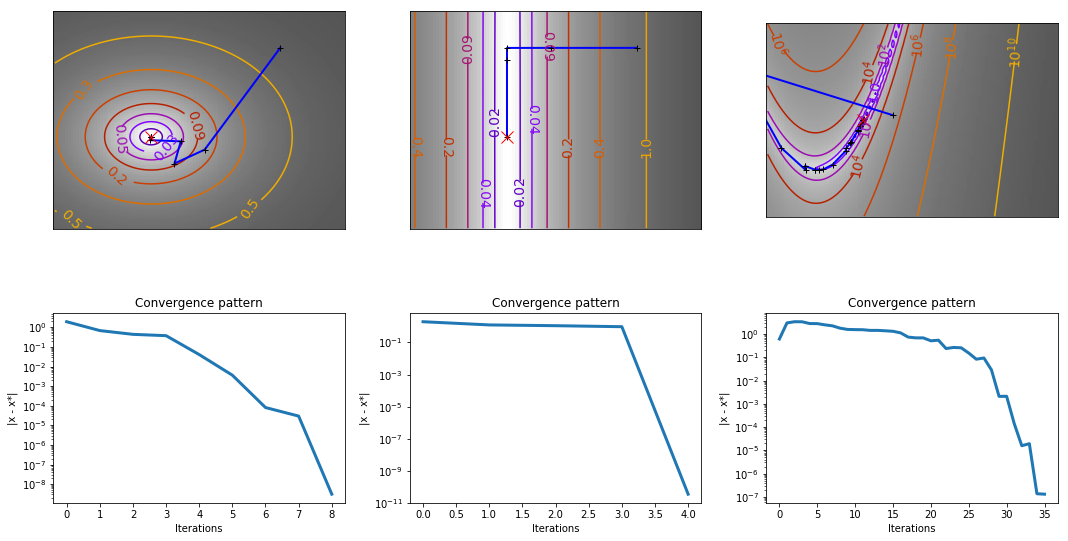

Running time :  3.408083200454712  seconds.


In [14]:
start = time.time()
test_solver(lbfgs)
print('Running time : ', time.time() - start,' seconds.')

#### Comments about L-BFGS algorithm :

|        | Function 1    | Function 2   | Function 3    |
|--------|---------------|--------------|---------------|
| BFGS   | 10 iterations | 6 iterations | 41 iterations |
| L-BFGS | 8 iterations  | 4 iterations | 35 iterations |

For quadratic functions, L-BFGS have some slight advantage comparing to BFGS. This also remains for non quadratic functions.

Actually, the advantage of L-BFGS is mosty in terms of memory (instead of storing a pxp hessian matrix we store 2M vectors of lenth p), the precision results however does not differ much from the BFGS as attested by the curves.